In [2]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
import sys, os, glob, pickle, struct
import plot_tools
import make_plots
from scipy import stats

In [17]:
def do_filter(a, b, lower_limit=1):
    """Filter two lists such that if one entry is invalid, both elements from the lists are removed."""
    
    def is_valid(elm):
        if elm is None:
            return False
        return elm > lower_limit and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]) or not is_valid(a[idx]) :
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b

def bin_stats(x, values):
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='mean', bins=25)
    bin_std, bin_edges, binnumber = stats.binned_statistic(x, values, statistic='std', bins=25)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_centers, bin_means, bin_std

In [5]:
path30  = "/scratch/hc2347/pickles/60/run0325_30_2.1407388896027233.p"
path60 = "/scratch/hc2347/pickles/60/Final60_2.1407388896027233.p"

entry30 = plot_tools.load_halos_pickle(path30)
entry60 = plot_tools.load_halos_pickle(path60)

/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


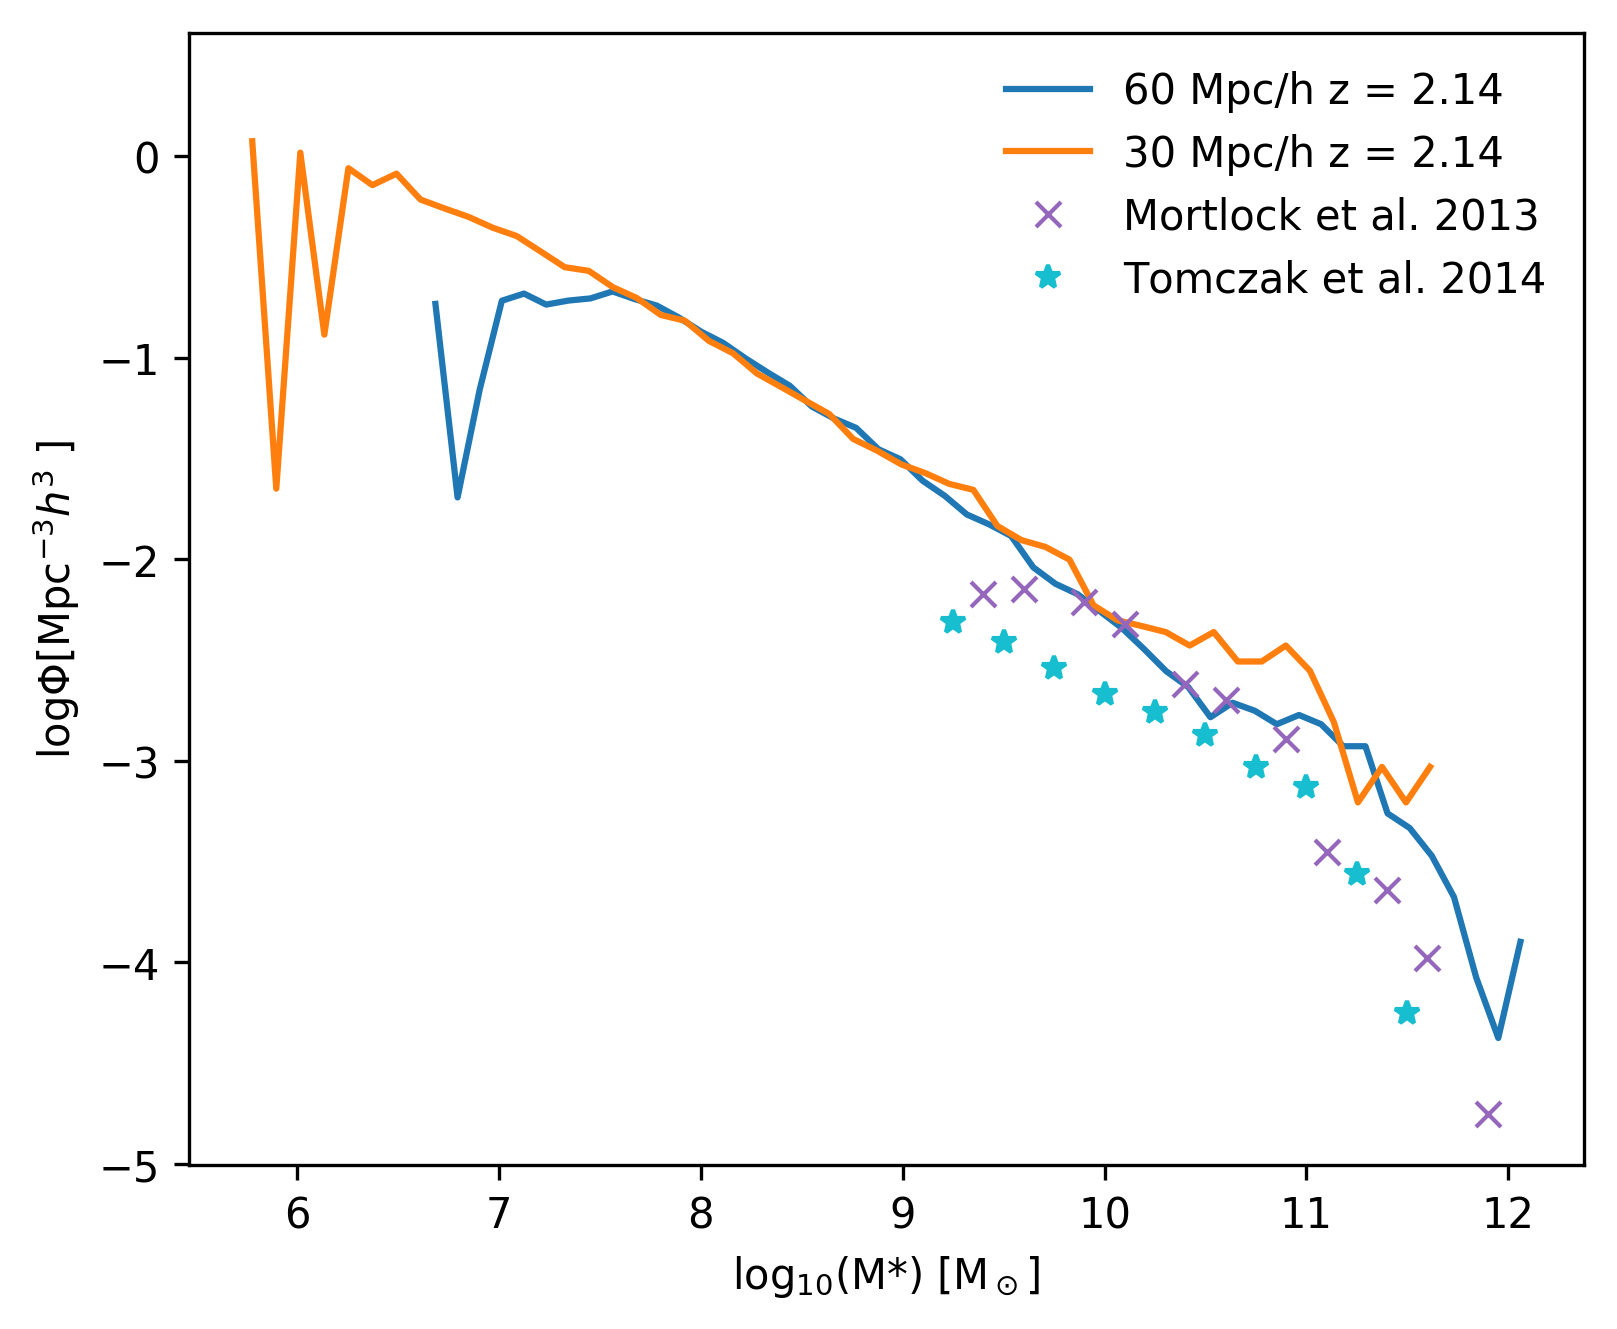

In [46]:
# Stellar Mass Function

sm30 = plot_tools.filter_list(entry30['mstar'], 1e-5, 1e20)
sm60 = plot_tools.filter_list(entry60['mstar'], 1e-5, 1e20)

fig, ax = plt.subplots(figsize=(6,5), dpi = 300)

def plot_smf(mstar, size, label):
    mstar = plot_tools.filter_list(mstar, 1, 1e20)
    logM = np.log10(mstar)
    nbins = 50
    V = size**3
    Phi, edg = np.histogram(logM, bins=nbins)    #Unnormalized histogram and bin edges
    dM = edg[1] - edg[0]
    Max = np.array(edg[0:-1]) + dM/2
    Phi = Phi/V/dM
    ax.plot(Max, np.log10(Phi), label=label)
    ax.fill_between(Max, np.log10(Phi + np.sqrt(Phi)), np.log10(Phi - np.sqrt(Phi)))

plot_smf(entry60['mstar'], 60, '60 Mpc/h z = 2.14')
plot_smf(entry30['mstar'], 30, '30 Mpc/h z = 2.14')
ax.set_ylabel(r'$\mathrm{log}\Phi [\mathrm{Mpc}^{-3} h^3$ ]')
ax.set_xlabel('log$_{10}$(M*) [M$_\odot$]')

mortlock2 = np.genfromtxt('obs/Mortlock_2013_SMF_z2.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(mortlock2[0], mortlock2[1], label="Mortlock et al. 2013", marker = 'x', linestyle = "None", color = 'tab:purple')
tomczak2 = np.genfromtxt('obs/Tomczak_2014_SMF_z2.csv', unpack=True, skip_header=1, delimiter=',')
ax.plot(tomczak2[0], tomczak2[4], ls = 'None', marker = '*', label = "Tomczak et al. 2014", color = 'tab:cyan')


ax.legend(frameon=False)
plt.savefig("/scratch/hc2347/reports/resolution_SMF.png")

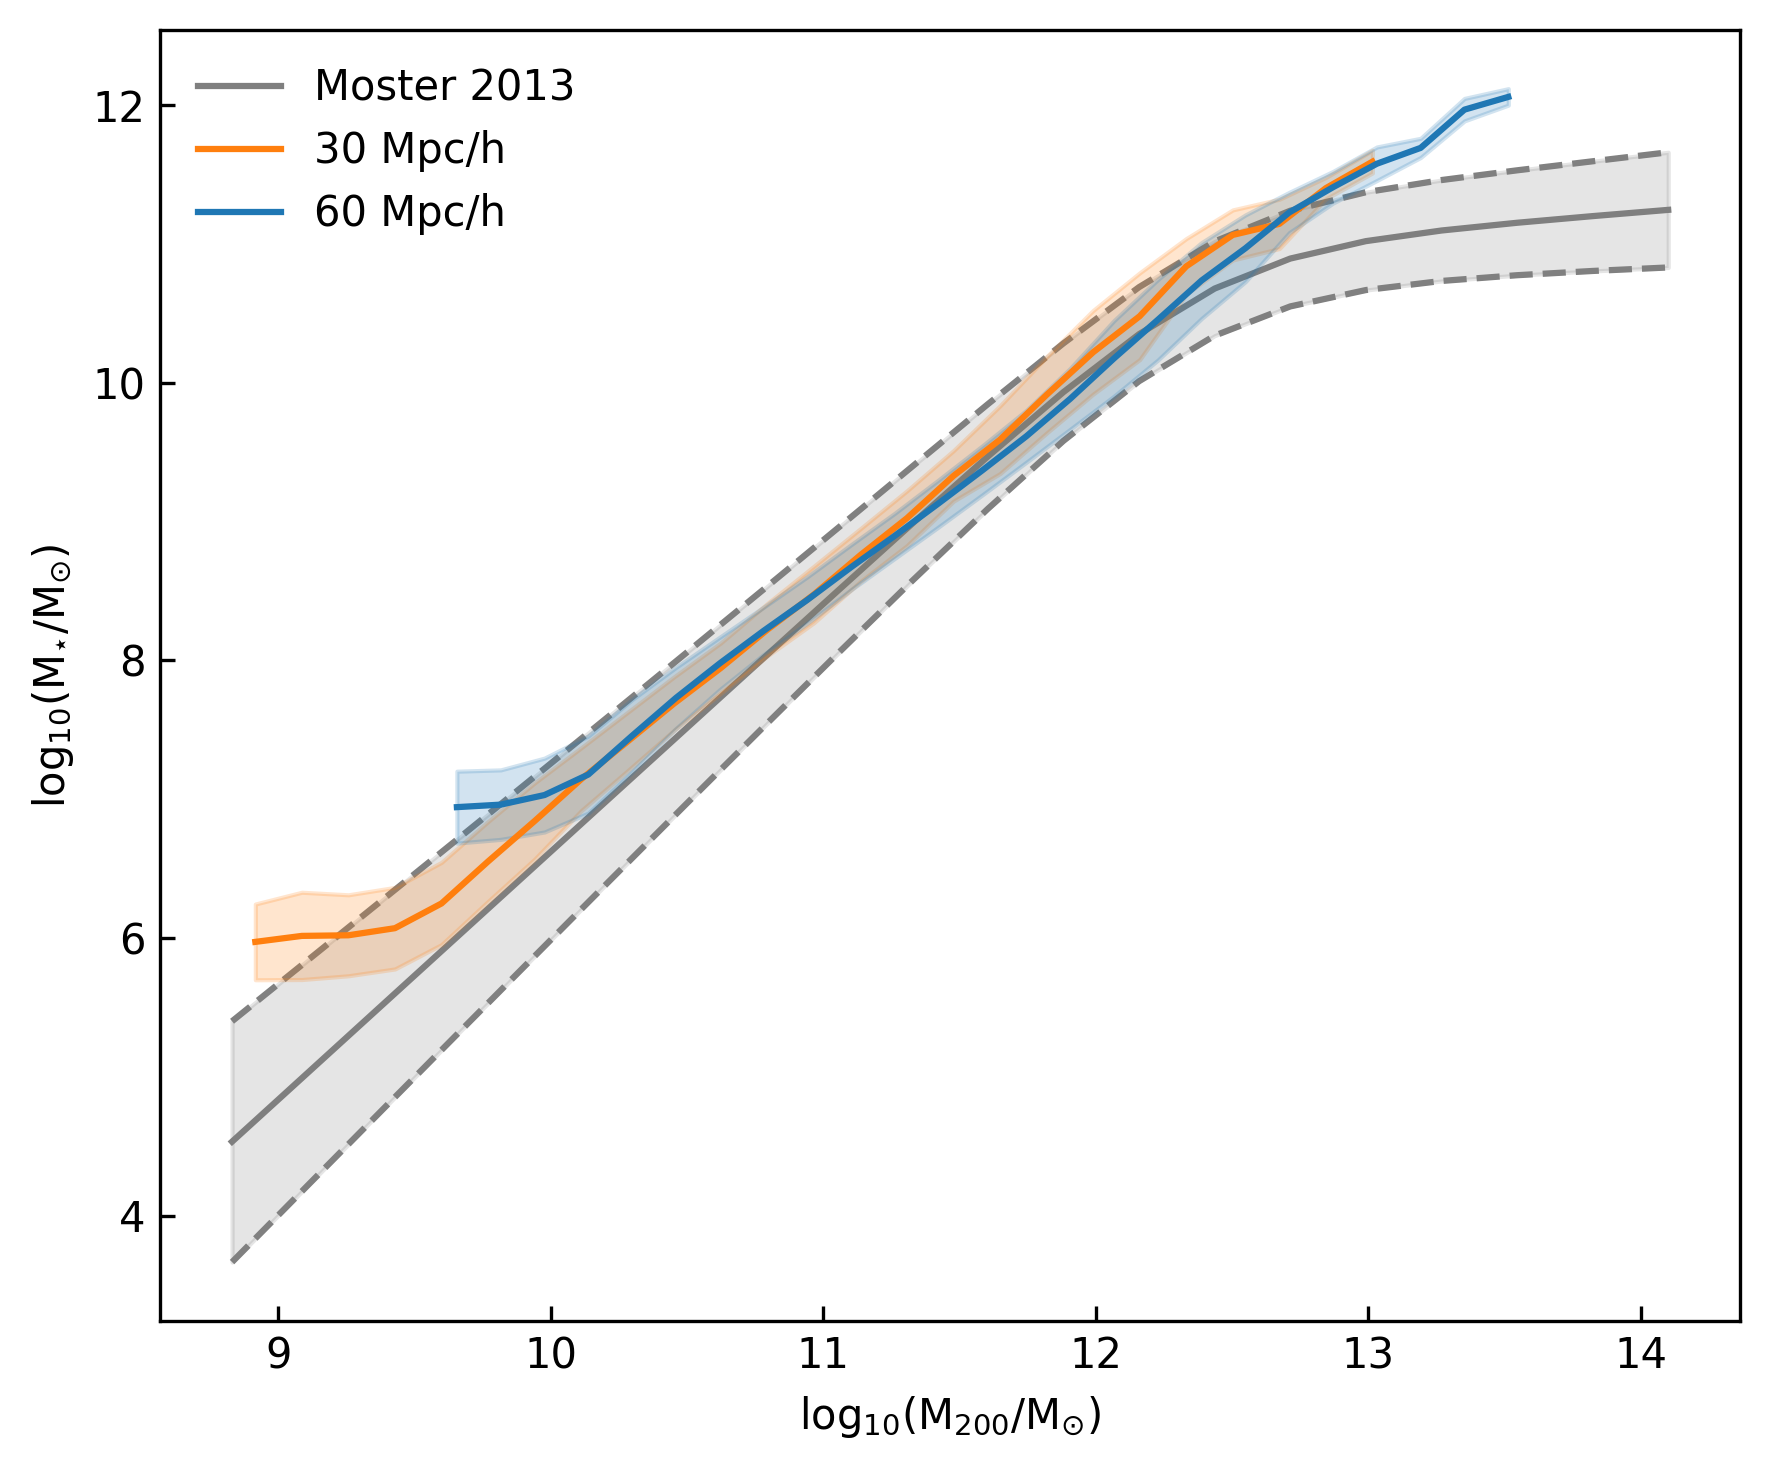

In [41]:
# Moster

from pynbody.plot.stars import moster

x30, y30 = plot_tools.do_filter(entry30['mvir'], entry30['mstar'], 1e-5)
x60, y60 = plot_tools.do_filter(entry60['mvir'], entry60['mstar'], 1e-5)
mc30, mm30, mstd30 = bin_stats(np.log10(x30), np.log10(y30))
mc60, mm60, mstd60 = bin_stats(np.log10(x60), np.log10(y60))

#for the 30
def moster_plot(x, zred):
    xmasses = np.logspace(np.log10(min(x)),1+np.log10(max(x)),20)
    ystarmasses, errors = moster(xmasses, zred)

    ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)),color="tab:grey",label="Moster 2013", zorder = -2)
    ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)), linestyle='dashed', zorder = -2, color = 'grey')
    ax.plot(np.log10(xmasses),np.log10(np.array(ystarmasses)*np.array(errors)), linestyle='dashed', zorder = -2, color = 'grey')
    ax.fill_between(np.log10(xmasses),np.log10(np.array(ystarmasses)/np.array(errors)),y2=np.log10(np.array(ystarmasses)*np.array(errors)),
                    color='tab:grey', alpha=0.2, zorder = -3)

fig, ax = plt.subplots(figsize=(6,5), dpi=300)
moster_plot(x30, 2.5)

ax.plot(mc30, mm30, label = '30 Mpc/h', color = 'tab:orange')
ax.fill_between(mc30, mm30 + mstd30, mm30 - mstd30, color = 'tab:orange', alpha = 0.2)
ax.plot(mc60, mm60, label = '60 Mpc/h', color = 'tab:blue')
ax.fill_between(mc60, mm60+mstd60, mm60-mstd60, color = 'tab:blue', alpha = 0.2)

xlabel = '$\\rm{log_{10}}(M_{200}/\\rm M_{\odot})$'
ylabel = '$\\rm{log_{10}}(M_{\star}/\\rm M_{\odot})$'
ax.legend(frameon=False)
ax.tick_params(direction='in', which='both')
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.tight_layout()
plt.savefig("/scratch/hc2347/reports/resolution_Moster.png")

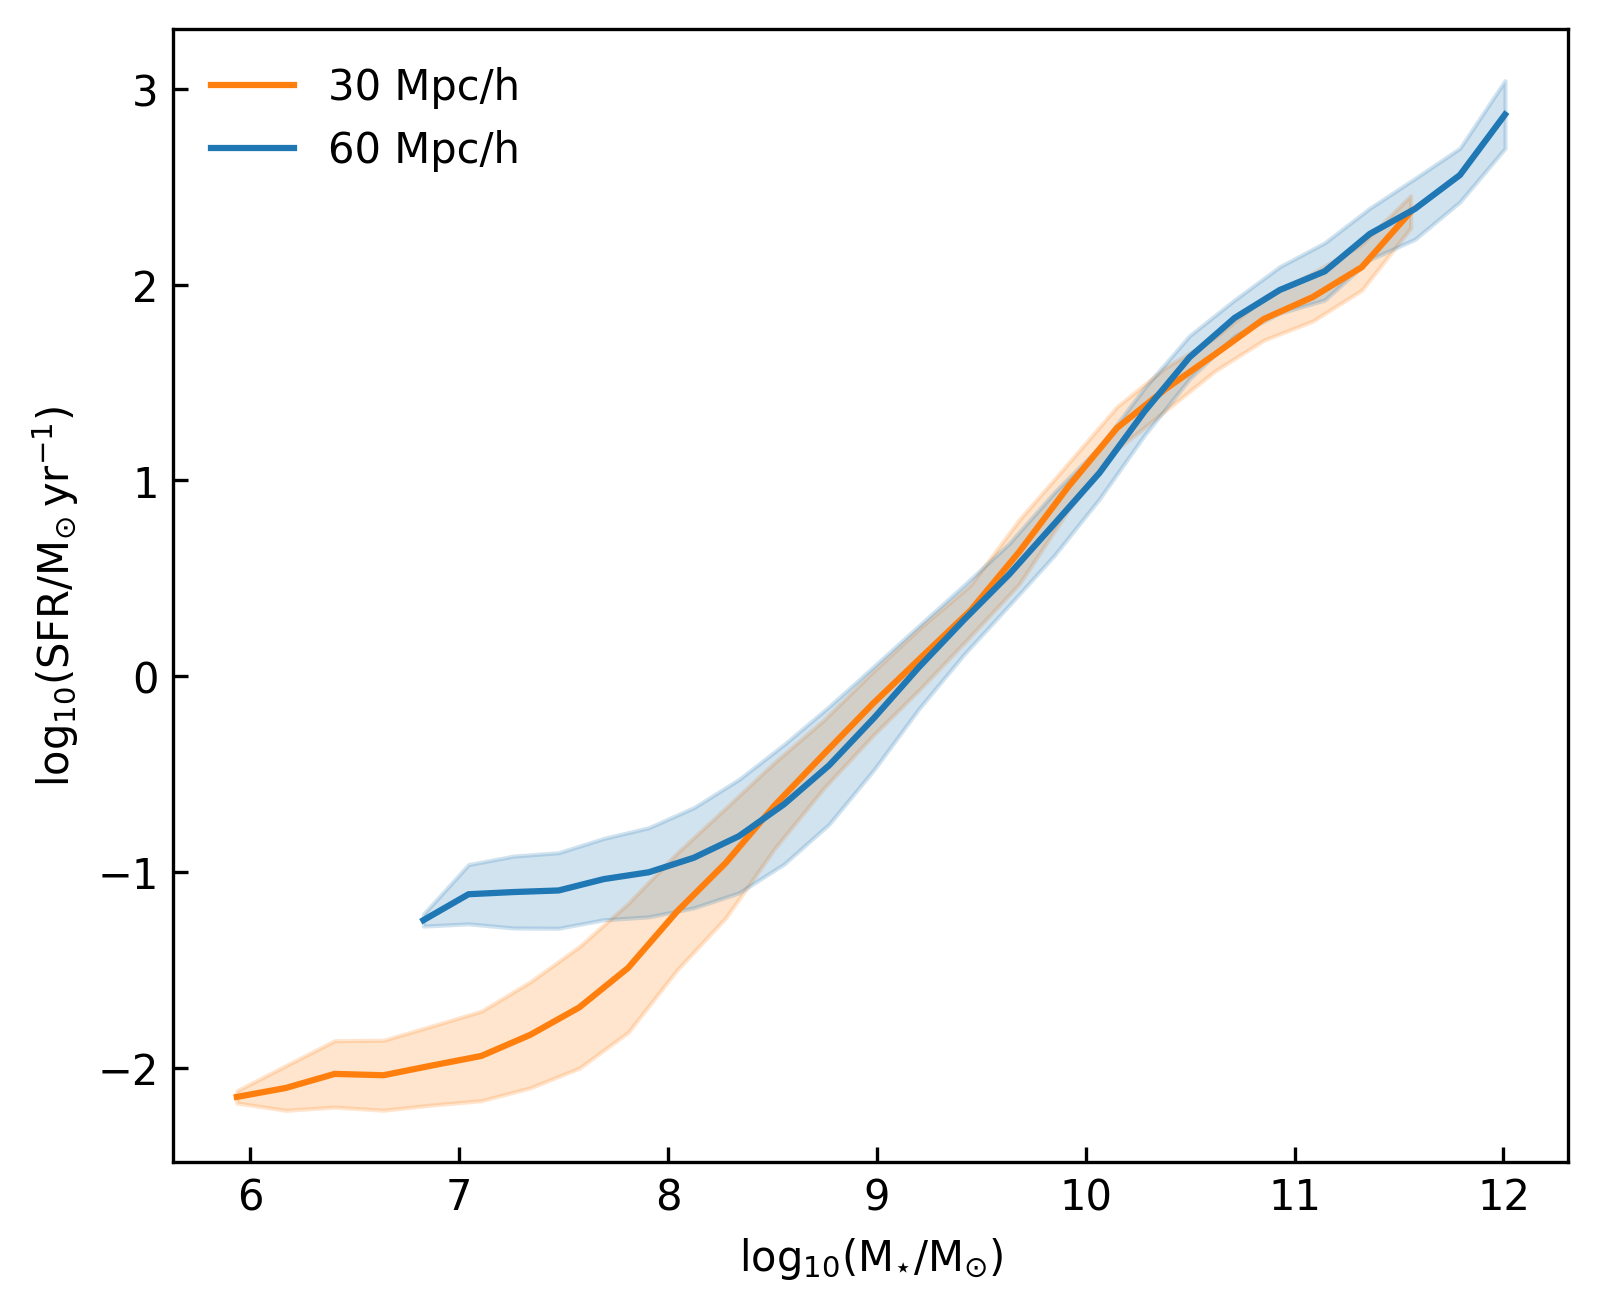

In [42]:
# SFR
def plot_SFR(entry, color, label):
    x, y = plot_tools.do_filter(entry['mstar'], entry['sfr_100'], 1e-10)
    c, m, std = bin_stats(np.log10(x),np.log10(y))
    ax.plot(c, m, color = color, label = label)
    ax.fill_between(c, m + std, m - std, color = color, linestyle = 'None', alpha = 0.2)

def SFR_Daddi(mstar):
    mstar = mstar/10**11
    sfr = 200*mstar**0.9
    return np.log10(sfr)

fig, ax = plt.subplots(figsize = (6,5), dpi = 300)

plot_SFR(entry30, 'tab:orange', "30 Mpc/h")
plot_SFR(entry60, 'tab:blue', "60 Mpc/h")

#ax.plot(np.log10(np.linspace(10**9, 10**12)), SFR_Daddi(np.linspace(10**9, 10**12)), label = 'Daddi et al. 2007')
#ax.fill_between(np.log10(np.linspace(10**9, 10**12)), SFR_Daddi(np.linspace(10**9, 10**12)), label = 'Daddi et al. 2007')

xlabel = '$\\rm{log_{10}}(M_{\star}/\\rm M_{\odot})$'
ylabel = '$\\rm{log_{10}(SFR/M_{\odot}\,yr^{-1})}$'

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.legend(frameon=False)
ax.tick_params(direction='in', which='both')

plt.savefig("/scratch/hc2347/reports/resolution_SFR.png")

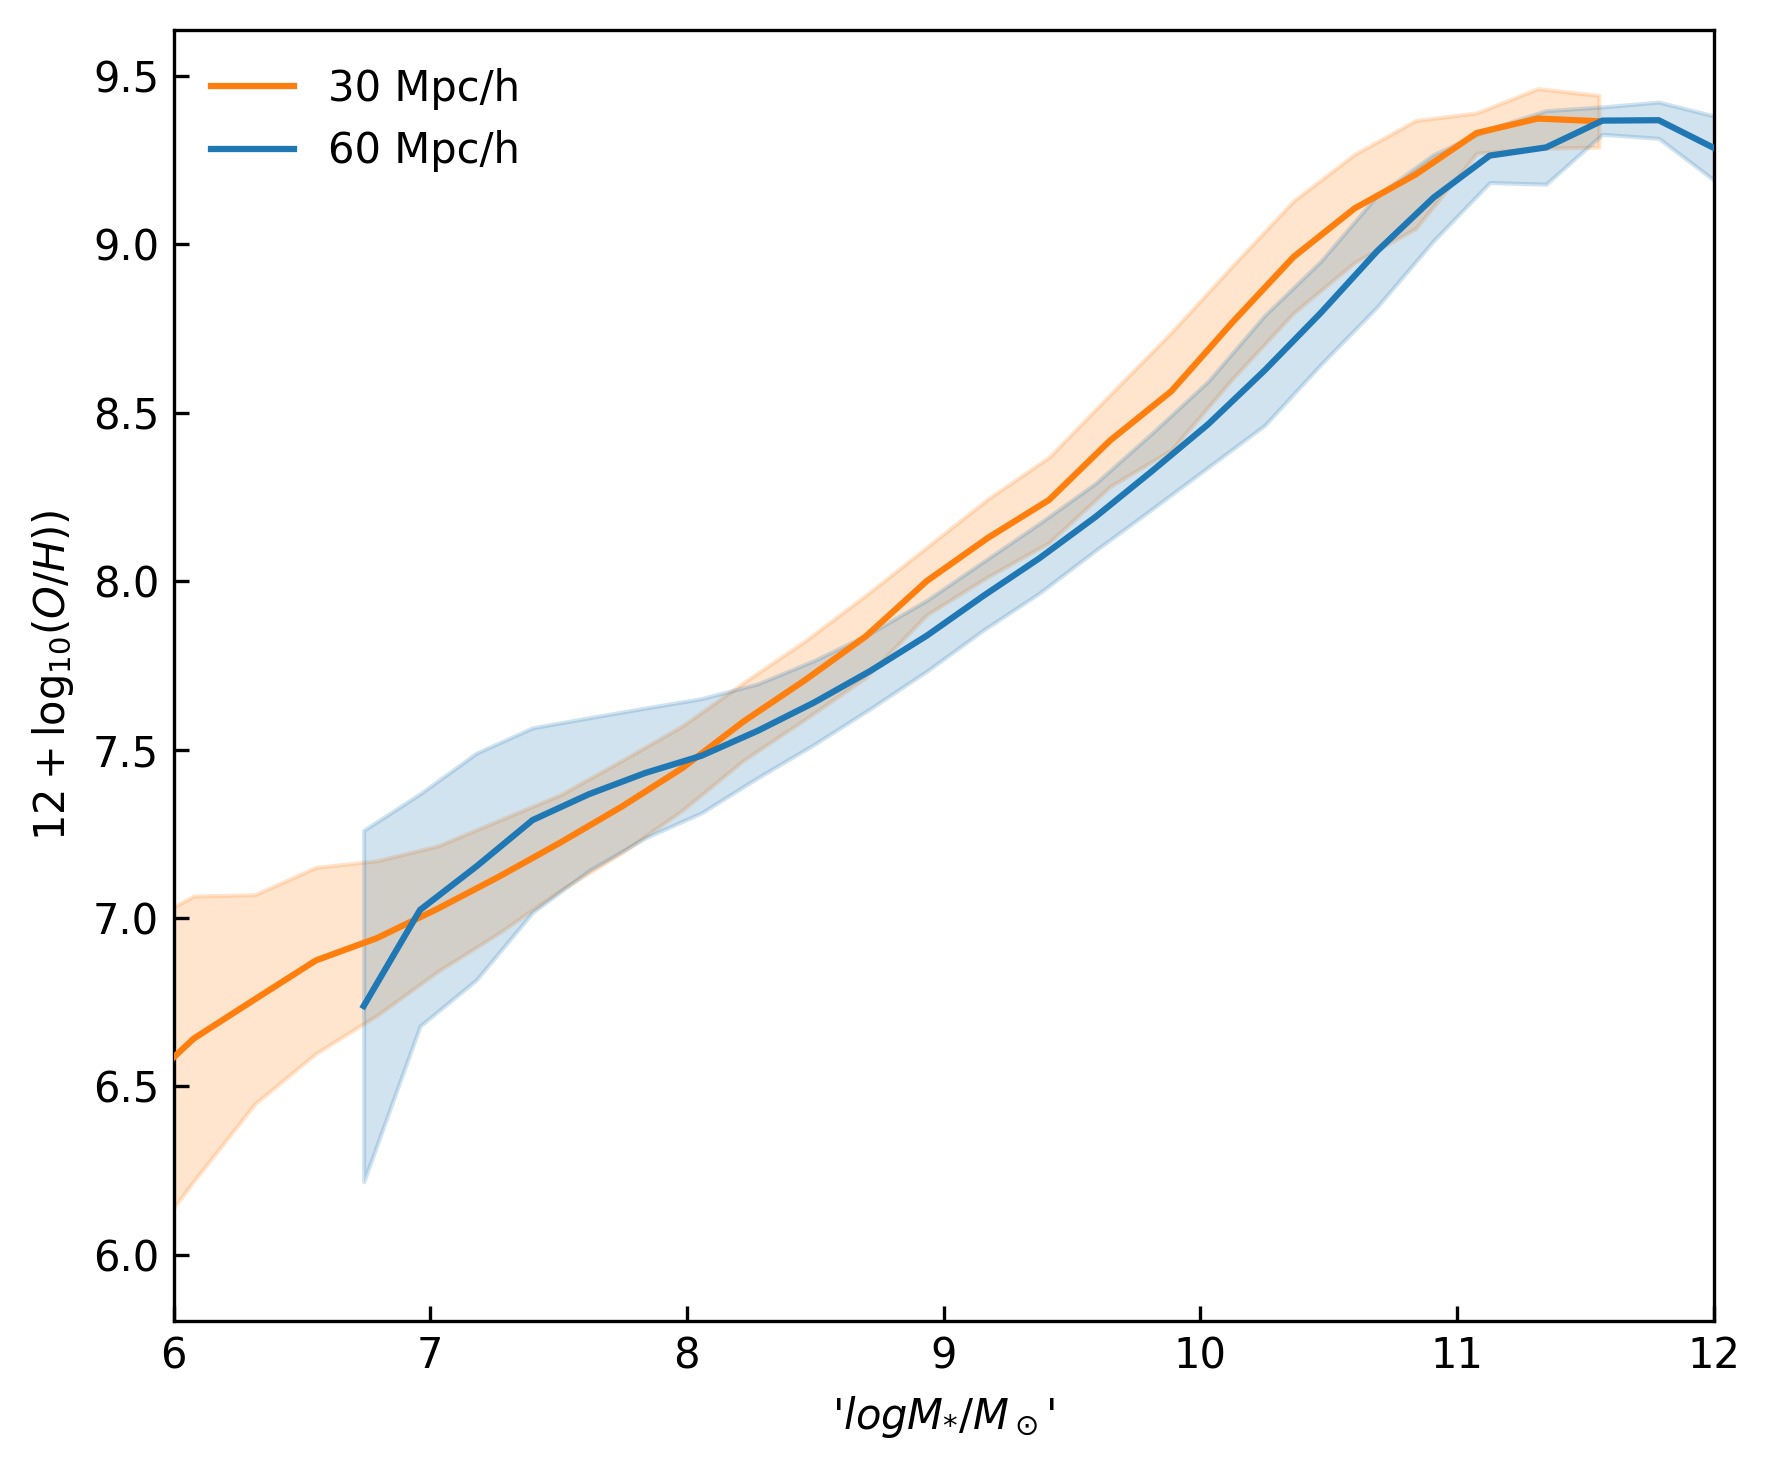

In [44]:
def plotoxh(entry, label, color):
    x = entry["mstar"]
    values = entry["oxh"]
    x, values = do_filter(x, values, 1e-5)
    centers, means, std = bin_stats(np.log10(x), values)
    
    ax.plot(centers, means, label = label, color = color, zorder = 9)
    ax.fill_between(centers, means+std, means-std, alpha = 0.2, color = color)

    ax.set(xlabel = "'$ log M_{*}/M_\odot$'", ylabel = '$12+\log_{10}(O/H))$', xlim = (6, 12))
    ax.legend(frameon=False)
    ax.tick_params(direction='in', which='both')
    
fig, ax = plt.subplots(figsize=(6,5), dpi = 300)
plotoxh(entry30, '30 Mpc/h', 'tab:orange')
plotoxh(entry60, '60 Mpc/h', 'tab:blue')
plt.tight_layout()
plt.savefig("/scratch/hc2347/reports/oxh_resolution.png")

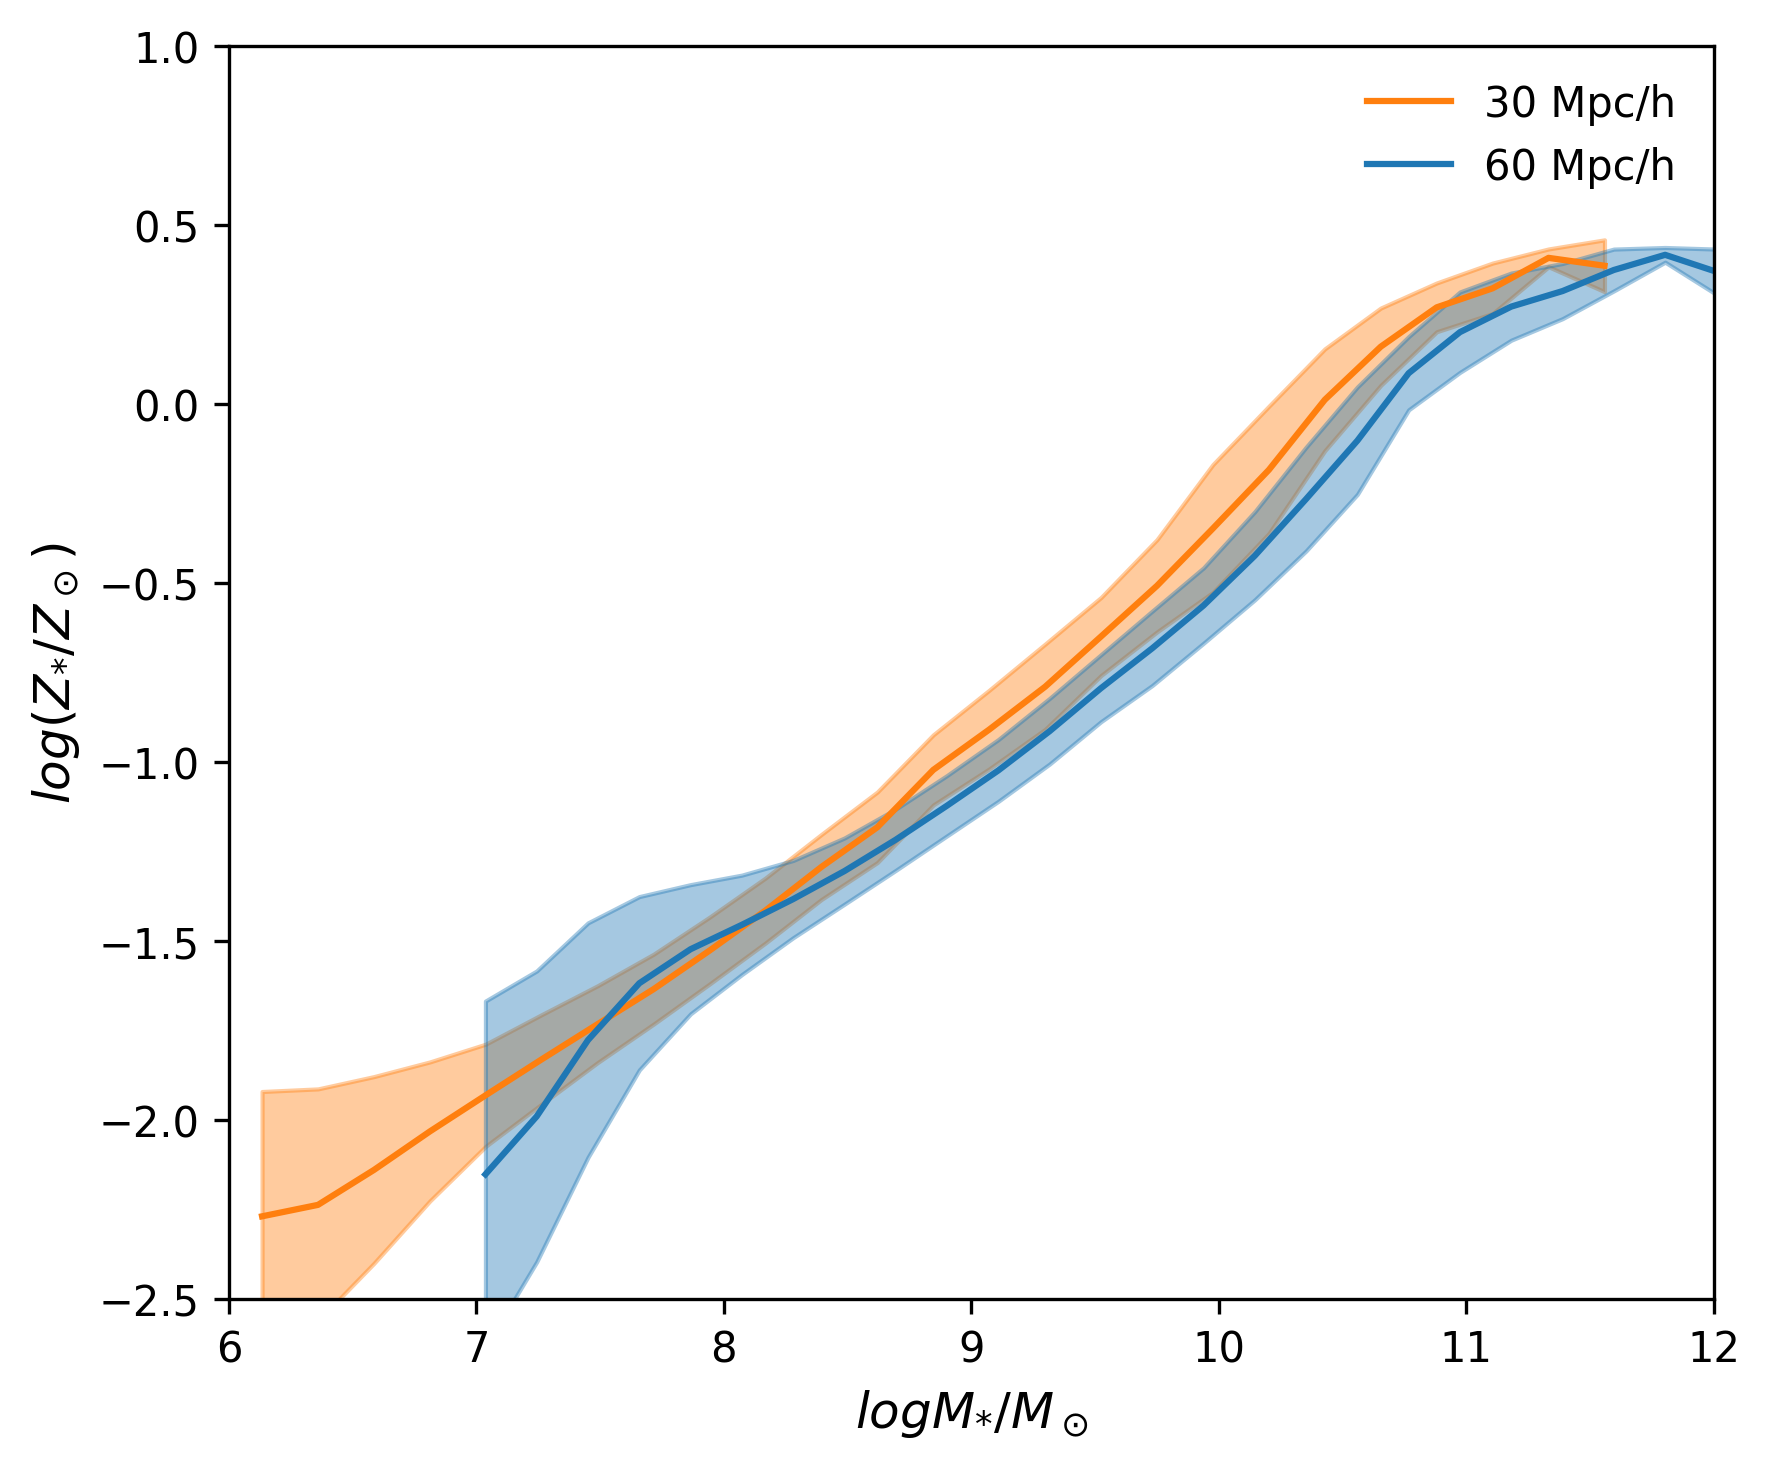

In [45]:
def plotzstar(entry, label, color):
    z_sol = 0.013 # primordial Solar metallicity

    x, y = do_filter(entry['mstar'], entry['zstar'], 1e-5)
    zsc, zsm, zsstd = bin_stats(np.log10(x), np.log10(y/z_sol))
    ax.plot(zsc, zsm, label = label, color = color)
    ax.fill_between(zsc, zsm+zsstd, zsm-zsstd, alpha = 0.4, color = color)
    
    ax.set_ylabel('$log(Z_{*}/Z_\odot)$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    ax.set(xlim = (6,12), ylim = (-2.5, 1))
    ax.legend(frameon=False)
    
fig, ax = plt.subplots(figsize=(6,5), dpi = 300)
plotzstar(entry30, '30 Mpc/h', 'tab:orange')
plotzstar(entry60, '60 Mpc/h', 'tab:blue')

plt.tight_layout()
plt.savefig("/scratch/hc2347/reports/zstar_resolution.png")
